# Notes:
Given that the data appeared to be linear combinations, I thoughht a MLP would work well. Early testing was promizing, but actually still did not outperform thhe linear regression, so I created a workflow to track my iterative progress


Determined the 4 best parforming architectures in testing on a subsample of train data:
1. 3 layer pyramid w/ 44 hidden units
2. 3 layer pyramid w/ 66 hidden units
3. 2 layer pyramid w/ 44 hidden units
4. 2 layer pyramid w/ 66 hidden units

Fix ID column


In [17]:

from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
import os
from datetime import datetime
import matplotlib.pyplot as plt


In [18]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# Pull the data from csv
train_full = pd.read_csv(os.getcwd() + '/data/train_transformed_full.csv', index_col=False)
test_full = pd.read_csv(os.getcwd() + '/data/test_transformed_full.csv', index_col=False)

val_size = 2000

train_full = train_full.sample(frac=0.1, random_state=42)  # 10% random sample

X_train_full = train_full.drop(columns=['target'])
y_train_full = train_full['target']

X_train = X_train_full.iloc[:-val_size]
y_train = y_train_full.iloc[:-val_size]

X_val = X_train_full.iloc[-val_size:]
y_val = y_train_full.iloc[-val_size:]

X_test = test_full.drop(columns=['target'])
y_test = test_full['target']

In [ ]:
batch_size = 25
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(y_train.shape[0], 1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(y_val.shape[0], 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(y_test.shape[0], 1)

# Create Dataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Define model architectures

In [19]:

#------------------------ 1 Layer Architectures ------------------------

class SingleLayerMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SingleLayerMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out= self.output(out)
        return out
    
#------------------------ 2 Layer Architectures ------------------------

# Stacked
class StackedDoubleLayerMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(StackedDoubleLayerMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out= self.fc2(out)
        out= self.relu2(out)
        out = self.output(out)
        return out

# Pyramid 
class PyramidDoubleLayerMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PyramidDoubleLayerMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, int(hidden_size/2))
        self.relu2 = nn.ReLU()
        self.output = nn.Linear(int(hidden_size/2), output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out= self.fc2(out)
        out= self.relu2(out)
        out = self.output(out)
        return out
    
#------------------------ 3 Layer Architectures ------------------------
      
# Stacked  
class StackedTripleLayerMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(StackedTripleLayerMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_size)
        
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out= self.fc2(out)
        out= self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out=self.output(out)
        return out
    
# Pyramid   
class PyramidTripleLayerMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PyramidTripleLayerMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, int(hidden_size/2))
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(int(hidden_size/2), int(hidden_size/4))
        self.relu3 = nn.ReLU()
        self.output = nn.Linear(int(hidden_size/4), output_size)
        
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out= self.fc2(out)
        out= self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out=self.output(out)
        return out
 


## Training and inference helpers

In [30]:
# Train function
def train_mlp(architecture, hidden_size, train_loader, val_loader, input_size=20, num_epochs=10):
    model = architecture(input_size=input_size, hidden_size=hidden_size, output_size=1)

    # Log the type of architecture for later tracking
    architecture_name = str(architecture).split('.')[-1]
    writer = SummaryWriter(f"runs/{architecture_name}/{hidden_size}/{timestamp}")
    
    # Define loss and optimizer
    criterion = nn.MSELoss()  
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Log a graph of the model
    sample_input = next(iter(train_loader))[0]
    writer.add_graph(model, sample_input)

    # GPU enables faster training
    device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Training loop
    num_epochs = num_epochs
    best_val_r2 = 0 # Criterion for saving best model
    for epoch in range(num_epochs):
        model.train(True) # Tracking on for training
        running_train_loss = 0
        running_train_r2 = 0
        
        for inputs, targets in train_loader: # Foreach batch:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs)
            train_loss = criterion(outputs, targets)
            # Backward pass, calculate the loss
            train_loss.backward()
            optimizer.step()
            running_train_loss += train_loss.item()
            # Calculate R2
            outputs_np = outputs.detach().cpu().numpy()
            targets_np = targets.detach().cpu().numpy()
            train_batch_r2 = r2_score(targets_np, outputs_np)
            running_train_r2 += train_batch_r2
            
           
        model.train(False) # Turn off tracking to validate
        running_val_loss = 0
        running_val_r2 = 0
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            # Make prediction
            outputs = model(inputs)
            # Compute loss
            val_loss = criterion(outputs, targets)
            running_val_loss += val_loss.item()
            #Calculate R2
            outputs_np = outputs.detach().cpu().numpy()
            targets_np = targets.detach().cpu().numpy()
            val_batch_r2 = r2_score(targets_np, outputs_np)
            running_val_r2 += val_batch_r2
            
        # Calculate avg loss and accuracy across all batches for the epoch
        train_loss_epoch = running_train_loss / len(train_loader)
        val_loss_epoch = running_val_loss / len(val_loader)
        train_r2_epoch = running_train_r2 / len(train_loader)
        val_r2_epoch =  running_val_r2 / len(val_loader)
        
        # Save best model based on validation R2
        if val_r2_epoch > best_val_r2:
            best_val_r2 = val_r2_epoch
            best_model_state = model.state_dict()
        
        metrics_dict = {
            'train loss': train_loss_epoch,
            'validation loss': val_loss_epoch,
            'train R2': train_r2_epoch,
            'validation R2': val_r2_epoch
        }
        
        writer.add_scalars('epochh_metrics', metrics_dict)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss_epoch:.5f}, Val Loss: {val_loss_epoch:.5f} ')
    
    # Save best model state and use it to build the best model
    
    best_model_path = f'models/best-{architecture_name}-{hidden_size}-{timestamp}.pt'
    torch.save(best_model_state, best_model_path) 

    best_model = architecture(input_size=input_size, hidden_size=hidden_size, output_size=1).load_state_dict(torch.load(best_model_path))
    
    return best_model    
    
    

In [21]:
# Inference function
def inference(model, input_data):
    model.eval()
    with torch.no_grad():
        predictions = model(input_data)
    return predictions

## Test model

In [31]:
selected_architecture = SingleLayerMLP
hidden_size = 20

best_model = train_mlp(architecture=selected_architecture,
                       hidden_size=hidden_size,
                       train_loader=train_loader,
                       val_loader=val_loader
                       )

train_preds = inference(best_model, X_train_tensor)
test_preds = inference(best_model, X_test_tensor)

Epoch [1/10], Loss: 0.00481, Val Loss: 0.00048 
Epoch [2/10], Loss: 0.00046, Val Loss: 0.00044 
Epoch [3/10], Loss: 0.00044, Val Loss: 0.00043 
Epoch [4/10], Loss: 0.00043, Val Loss: 0.00043 
Epoch [5/10], Loss: 0.00042, Val Loss: 0.00041 
Epoch [6/10], Loss: 0.00042, Val Loss: 0.00042 
Epoch [7/10], Loss: 0.00041, Val Loss: 0.00041 


In [27]:
type(best_model)

torch.nn.modules.module._IncompatibleKeys

In [ ]:
# Visualize Results of best model
test_preds = inference(model, X_test_tensor).numpy()
train_preds = inference(model, X_train_tensor).numpy()




# Evaluate the model
train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)
# Calculate residuals

train_residuals = y_train - train_preds
test_residuals = y_test - test_preds

print(f"Train R² Score: {train_r2}")
print(f"Test R² Score: {test_r2}")

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=train_preds, y=train_residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.title('Train Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
sns.scatterplot(x=test_preds, y=test_residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.title('Test Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

In [9]:
# # Model parameters
# input_size = X_train_tensor.shape[1]
# hidden_size = 20 
# output_size = 1  # Single continuous value for regression

# # Create the model 
# selected_architecture = SingleLayerMLP

# model = selected_architecture(input_size, hidden_size, output_size)

# writer = SummaryWriter(f"runs/{selected_architecture}/{hidden_size}/{timestamp}")

# # Define loss and optimizer
# criterion = nn.MSELoss()  
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# sample_input, sample_targets = next(iter(train_loader))
# writer.add_graph(model, sample_input)

# device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

# # Training loop
# num_epochs = 10

# best_val_r2 = 0

# for epoch in range(num_epochs):
    
#     # Train
#     model.train(True)
#     running_train_loss = 0
#     running_train_r2 = 0
    
#     for inputs, targets in train_loader:
#         inputs, targets = inputs.to(device), targets.to(device)
#         optimizer.zero_grad()
#         # Forward pass
#         outputs = model(inputs)
#         train_loss = criterion(outputs, targets)
#         # Backward pass
#         train_loss.backward()
#         optimizer.step()
#         running_train_loss += train_loss.item()
#         # Calculate R2
#         outputs_np = outputs.detach().cpu().numpy()
#         targets_np = targets.detach().cpu().numpy()
#         train_batch_r2 = r2_score(targets_np, outputs_np)
#         running_train_r2 += train_batch_r2
        
#     # Validate 
#     model.train(False) # Turn off tracking to validate
#     running_val_loss = 0
#     running_val_r2 = 0

#     for inputs, targets in val_loader:
#         inputs, targets = inputs.to(device), targets.to(device)
#         # Make prediction
#         outputs = model(inputs)
#         # Compute loss
#         val_loss = criterion(outputs, targets)
#         running_val_loss += val_loss.item()
#         #Calculate R2
#         outputs_np = outputs.detach().cpu().numpy()
#         targets_np = targets.detach().cpu().numpy()
#         val_batch_r2 = r2_score(targets_np, outputs_np)
#         running_val_r2 += val_batch_r2
     
#     # Compute the averages for each metric across all batches in the epochh   
#     train_loss_epoch = running_train_loss / len(train_loader)
#     val_loss_epoch = running_val_loss / len(val_loader)
#     train_r2_epoch = running_train_r2 / len(train_loader)
#     val_r2_epoch =  running_val_r2 / len(val_loader)
    
#     metrics_dict = {
#         'train loss': train_loss_epoch,
#         'validation loss': val_loss_epoch,
#         'train R2': train_r2_epoch,
#         'validation R2': val_r2_epoch
#     }
    
#     # Best Model Logging
#     if val_r2_epoch > best_val_r2:
#         best_val_r2 = val_r2_epoch
#         best_model_state = model.state_dict()
#         best_model_metrics = metrics_dict
        
#     #writer.add_scalar('Loss/Train Loss', train_loss.item(), epoch + 1)
#     #writer.add_scalar('Loss/Validation Loss', val_loss.item(), epoch + 1)


#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss_epoch:.5f}, Val Loss: {val_loss_epoch:.5f} ')
    
# best_model_path = 'models/model_{}_{}'.format(timestamp, (epoch + 1))
# torch.save(best_model_state, best_model_path)
# #writer.add_scalars(main_tag='best model metrics', tag_scalar_dict = best_model_metrics)

# print("Training complete")

Epoch [1/10], Loss: 0.00226, Val Loss: 0.00046 
Epoch [2/10], Loss: 0.00043, Val Loss: 0.00042 
Epoch [3/10], Loss: 0.00041, Val Loss: 0.00040 
Epoch [4/10], Loss: 0.00040, Val Loss: 0.00040 
Epoch [5/10], Loss: 0.00040, Val Loss: 0.00040 
Epoch [6/10], Loss: 0.00040, Val Loss: 0.00040 
Epoch [7/10], Loss: 0.00040, Val Loss: 0.00040 
Epoch [8/10], Loss: 0.00040, Val Loss: 0.00039 
Epoch [9/10], Loss: 0.00040, Val Loss: 0.00039 
Epoch [10/10], Loss: 0.00040, Val Loss: 0.00040 
Training complete


In [10]:
# Example inference on the test set
best_model= selected_architecture(input_size, hidden_size, output_size).load_state_dict(torch.load(best_model_path))

predictions = inference(model, X_test_tensor)

test_score = r2_score(predictions, y_test_tensor)
train_score = r2_score(inference(model, X_train_tensor), y_train_tensor)
print(f'training r2: {train_score:.4f}, test r2: {test_score:.4f}')

writer.add_scalar('test_r2', test_score)

training r2: 0.8174, test r2: 0.8184


In [11]:
# Convert tensors to numpy arrays
actual_np = y_test_tensor.numpy()
predicted_np = predictions.numpy()

# Calculate residuals
residuals = actual_np - predicted_np

fig, ax = plt.subplots(figsize=(10, 6))

# Plot residuals
ax.scatter(predicted_np, residuals, color='blue', edgecolors='k', alpha=0.7)
ax.hlines(0, min(predicted_np) - 1, max(predicted_np) + 1, colors='r', linestyles='dashed')
ax.set_title('Residual Plot')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')

residual_plot_figure = fig

writer.add_figure('residuals', figure=residual_plot_figure)

writer.close()


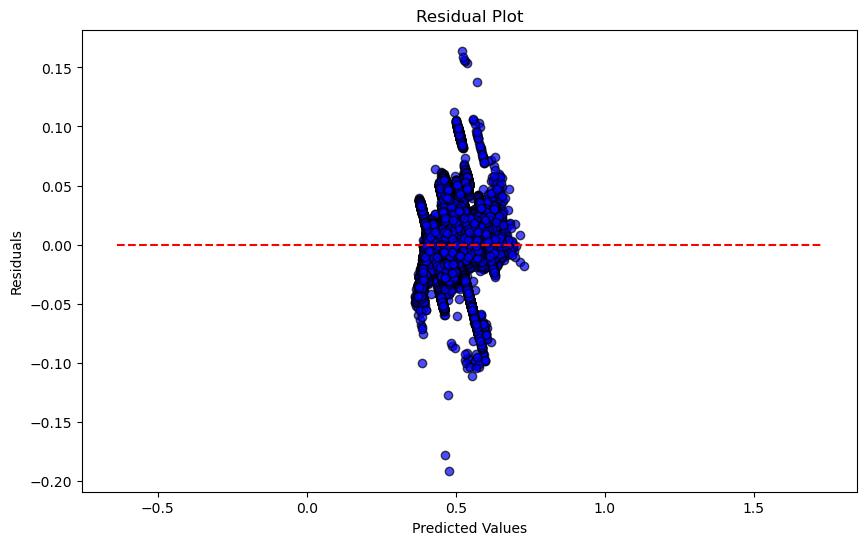

In [12]:
residual_plot_figure

In [13]:
test_preds = inference(model, X_test_tensor).numpy()
train_preds = inference(model, X_train_tensor).numpy()


# Evaluate the model
train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)
# Calculate residuals

train_residuals = y_train - train_preds
test_residuals = y_test - test_preds

print(f"Train R² Score: {train_r2}")
print(f"Test R² Score: {test_r2}")

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=train_preds, y=train_residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.title('Train Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
sns.scatterplot(x=test_preds, y=test_residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.title('Test Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

: 

In [ ]:
# started w/ hidden size = 50, 10 epochs, batch size = 25
submission_dataset = pd.read_csv('./data/submission_features.csv')

submission_ids = submission_dataset['id']
submission_features = submission_dataset.drop(columns=['id'])
submission_feature_tensor = torch.tensor(submission_features.values, dtype=torch.float32)

submission_preds = inference(model, submission_feature_tensor)

In [ ]:
result_df = pd.DataFrame(data= {
    'id' : submission_ids,
    'FloodProbability' : submission_preds.view(submission_preds.shape[0]).numpy()
})

In [ ]:
result_df

,id,FloodProbability
0,1117957,0.571551
1,1117958,0.452386
2,1117959,0.450154
3,1117960,0.470129
4,1117961,0.470450
...,...,...
745300,1863257,0.475481
745301,1863258,0.441901
745302,1863259,0.618190
745303,1863260,0.550216


In [ ]:
result_df.to_csv('./result.csv', index=False)

In [ ]:
predictions

tensor([[0.5271],
        [0.3971],
        [0.5765],
        ...,
        [0.5663],
        [0.4750],
        [0.5393]])